#Complex Image Classification with CNN

###First part of the code (displaying data) by: Laurence Moroney

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip  -O /tmp/horse-or-human.zip

--2021-10-18 15:05:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  40.3MB/s    in 3.5s    

2021-10-18 15:05:56 (40.3 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import os
import zipfile
 
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
 
# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])
train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse22-8.png', 'horse34-4.png', 'horse36-7.png', 'horse49-2.png', 'horse13-5.png', 'horse17-7.png', 'horse21-0.png', 'horse28-4.png', 'horse35-1.png', 'horse21-9.png']
['human01-00.png', 'human04-02.png', 'human06-01.png', 'human07-23.png', 'human11-16.png', 'human08-26.png', 'human17-10.png', 'human07-04.png', 'human08-17.png', 'human07-21.png']


In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


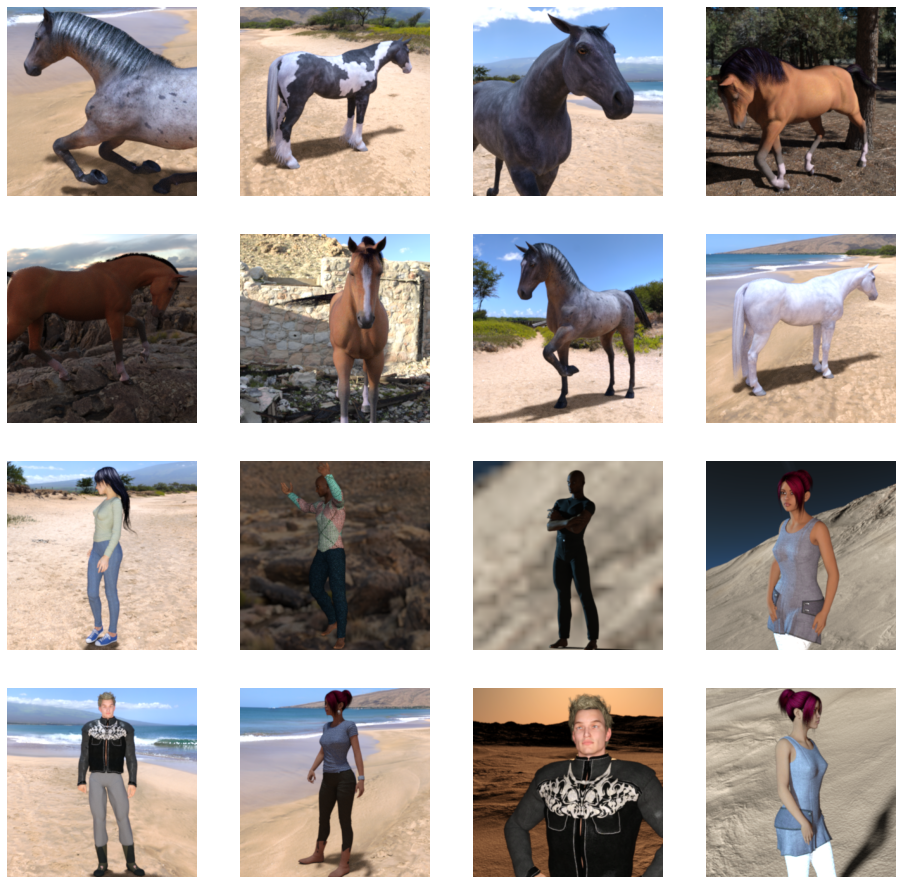

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimpg

# Let's display 16 photographs, 4x4 configuration
nrows = 4
ncols = 4
img_ind = 0

figure = plt.gcf()
figure.set_size_inches(ncols*4, nrows*4)

img_ind += 8
next_horse_img = [os.path.join(train_horse_dir, fname) for fname in train_horse_names[img_ind-8:img_ind]]
next_human_img = [os.path.join(train_human_dir, fname) for fname in train_human_names[img_ind-8:img_ind]]

for i, img_path in enumerate(next_horse_img+next_human_img):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  img = mpimpg.imread(img_path)
  plt.imshow(img)

plt.show()

## Loading and preprocessing data

In [7]:
import cv2
import glob
import numpy as np

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
pip install pycuda

     |████████████████████████████████| 1.7 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 63 kB 2.6 MB/s 
     |████████████████████████████████| 75 kB 5.9 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627466 sha256=c813813bb76c5e4966659a2986f51f7fcfecc2ef9ad945f73e7d8375a6eaade9
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=561d0df3f50545b23b56dfc7802c7d91f31336269b2845359926ca7ac03c9bb3
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


In [11]:

import tensorflow as tf
data_path1 = os.path.join('/tmp/horse-or-human/horses', '*g')
data_path2 = os.path.join('/tmp/horse-or-human/humans', '*g')
files1 = glob.glob(data_path1)
files2 = glob.glob(data_path2)
files1.sort()
files2.sort()
image = []

for f1 in files1:
  img = cv2.imread(f1)
  image.append(img)

for f2 in files2:
  img = cv2.imread(f2)
  image.append(img)

for i in range(0, 1027):
  image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2GRAY)
  image[i] = cv2.resize(image[i], (150, 150)) # 

In [89]:
image[0].shape

(150, 150)

In [12]:
# Let's label first 527 pictures as horses, other 500 pictures as humans
# Horse Label: 0, Human label: 1
labels = np.zeros(1027)
labels[0:527] = 0
labels[527:1027] = 1

In [13]:
images = np.array(image)

In [14]:
# Shuffle images and labels in such way that the corresponding elements continue to correspond!

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

shuffled_images, shuffled_labels = unison_shuffled_copies(images, labels)

In [15]:
# Normalize and split the training and testing data
train_images = shuffled_images[0:950,:,:]
train_labels = shuffled_labels[0:950]
test_images = shuffled_images[950:1027,:,:]
test_labels = shuffled_labels[950:1027]
train_images = train_images/255
test_images = test_images/255

In [16]:
# Before building NN, reshape each dataset into a 4dim tensor
train_images = train_images.reshape(950,150,150,1)
test_images = test_images.reshape(1027-950,150,150,1)

In [95]:
train_images[0].shape, train_labels.shape

((150, 150, 1), (950,))

In [17]:
train_labels = np.asarray(train_labels).astype('float32').reshape((-1,1))
test_labels = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [18]:
train_images = np.asarray(train_images).astype('float32')
test_images = np.asarray(test_images).astype('float32')

In [22]:
test_images.shape

(77, 150, 150, 1)

## Bulding CNN

In [109]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), input_shape=(150,150,1), activation="relu"),
  tf.keras.layers.MaxPool2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")                           
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.fit(train_images, train_labels, batch_size=1, epochs=5)

Epoch 1/5
950/950 [==============================] - 26s 27ms/step - loss: 0.5507 - accuracy: 0.7926
Epoch 2/5
950/950 [==============================] - 26s 27ms/step - loss: 0.2750 - accuracy: 0.8800
Epoch 3/5
950/950 [==============================] - 26s 27ms/step - loss: 0.1483 - accuracy: 0.9389
Epoch 4/5
950/950 [==============================] - 25s 26ms/step - loss: 0.0728 - accuracy: 0.9747
Epoch 5/5
950/950 [==============================] - 25s 26ms/step - loss: 0.1008 - accuracy: 0.9611


In [110]:
model.evaluate(test_images, test_labels)

3/3 [==============================] - 0s 100ms/step - loss: 0.0259 - accuracy: 0.9870


[0.025901328772306442, 0.9870129823684692]

## An amazing accuracy of 98.7%!

## Let's see examples.

## Label Reminder: Horse - 0, Human - 1

## Some examples of correctly classified images

In [97]:
if np.round(model.predict(test_images)[0])[0] == 0:
  print("It's a horse!")
if np.round(model.predict(test_images)[0])[0] == 1:
  print("It's a human!")

It's a horse!


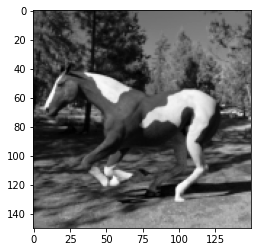

In [98]:
plt.imshow(test_images[0].reshape(150,150), cmap='Greys_r')


In [99]:
if np.round(model.predict(test_images)[1])[0] == 0:
  print("It's a horse!")
if np.round(model.predict(test_images)[1])[0] == 1:
  print("It's a human!")

It's a human!


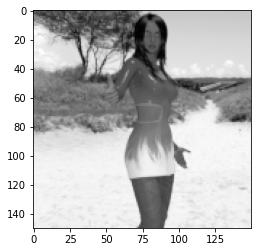

In [100]:
plt.imshow(test_images[1].reshape(150,150), cmap='Greys_r')

In [101]:
if np.round(model.predict(test_images)[3])[0] == 0:
  print("It's a horse!")
if np.round(model.predict(test_images)[3])[0] == 1:
  print("It's a human!")

It's a horse!


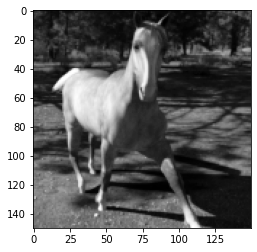

In [102]:
plt.imshow(test_images[3].reshape(150,150), cmap='Greys_r')

## Examples of wrongfully classified image (there really aren't many!)

In [111]:
if np.round(model.predict(test_images)[20])[0] == 0:
  print("It's a horse!")
if np.round(model.predict(test_images)[20])[0] == 1:
  print("It's a human!")

It's a horse!


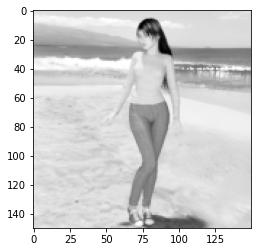

In [112]:
plt.imshow(test_images[20].reshape(150,150), cmap='Greys_r')

## How about loading some random pictures of horse/human from the internet?

## The goal of CNN is to correctly classify the image no matter if the picture is from real life or cartoon (caricature).

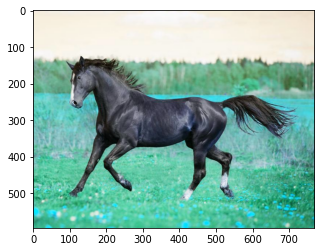

In [181]:
import urllib

req = urllib.request.urlopen('https://horsej-intellectsolutio.netdna-ssl.com/files/styles/article_large/public/pictures-videos/blogs/shutterstock_250751620_-_grigorita_ko_-_web.jpg?itok=dr2UJXfv')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1 = cv2.imdecode(arr, -1)
plt.imshow(img1, cmap='Greys_r')

In [182]:
img1 = cv2.resize(img1, (150,150)) # Resizing to 150x150
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) # Translating to greyscale channel
img1 = img1.reshape(1,150,150,1)
if model.predict(img1)[0] == 0:
  print("It's a horse!")

It's a horse!


## Picture above is clasified as a horse!

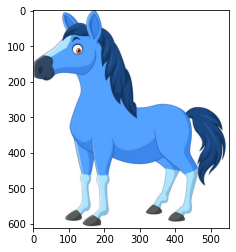

In [192]:
req = urllib.request.urlopen('https://media.istockphoto.com/vectors/cartoon-brown-horse-isolated-on-white-background-vector-id1179485280?k=20&m=1179485280&s=612x612&w=0&h=k5pMBbbvPL00k02bgKB2zA5bvu46Ag7v6_L52GO-Y4A=')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
plt.imshow(img, cmap='Greys_r')

In [193]:
img = cv2.resize(img, (150,150)) # Resizing to 150x150
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Translating to greyscale channel
img = img.reshape(1,150,150,1)
if model.predict(img)[0] == 0:
  print("It's a horse!")

It's a horse!


## Picture above is classified as a horse!

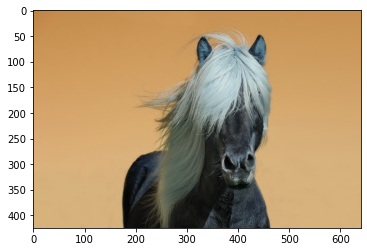

In [183]:
req = urllib.request.urlopen('https://developers.google.com/codelabs/tensorflow-5-compleximages/img/c9213173d9f3d83c.jpeg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img2 = cv2.imdecode(arr, -1)
plt.imshow(img2, cmap='Greys_r')

In [184]:
img2 = cv2.resize(img2, (150,150)) # Resizing to 150x150
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) # Translating to greyscale channel
img2 = img2.reshape(1,150,150,1)
if model.predict(img2)[0] == 0:
  print("It's a horse!")

It's a horse!


## Picture above is classifed as a horse!

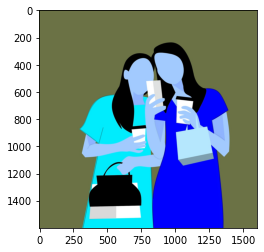

In [185]:
req = urllib.request.urlopen('https://developers.google.com/codelabs/tensorflow-5-compleximages/img/9e07a57ff3be7a82.jpeg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img3 = cv2.imdecode(arr, -1)
plt.imshow(img3, cmap='Greys_r')

In [186]:
img3 = cv2.resize(img3, (150,150)) # Resizing to 150x150
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY) # Translating to greyscale channel
img3 = img3.reshape(1,150,150,1)
if model.predict(img3)[0] == 1:
  print("It's a human!")

It's a human!


## Picture above is clasified as a human!

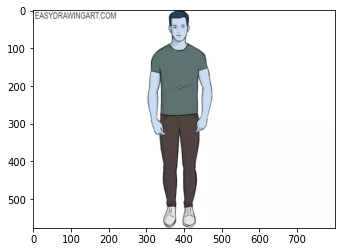

In [187]:
req = urllib.request.urlopen('https://easydrawingart.com/wp-content/uploads/2019/08/How-to-draw-a-human-1.jpg.webp')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img4 = cv2.imdecode(arr, -1)
plt.imshow(img4, cmap='Greys_r')

In [188]:
img4 = cv2.resize(img4, (150,150)) # Resizing to 150x150
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY) # Translating to greyscale channel
img4 = img4.reshape(1,150,150,1)
if model.predict(img4)[0] == 1:
  print("It's a human!")

It's a human!


## Picture above is classified as a human!

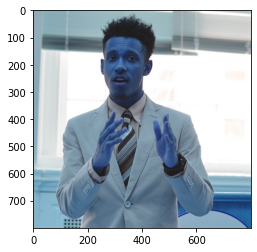

In [189]:
req = urllib.request.urlopen('https://www.human.cornell.edu/sites/default/files/styles/square_800x800/public/2017-12/20170324_rice_speaking%20%2812%29.jpg?itok=VIkygY6L')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img5 = cv2.imdecode(arr, -1)
plt.imshow(img5, cmap='Greys_r')

In [190]:
img5 = cv2.resize(img5, (150,150)) # Resizing to 150x150
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY) # Translating to greyscale channel
img5 = img5.reshape(1,150,150,1)
if model.predict(img5)[0] == 1:
  print("It's a human!")

It's a human!


## Picture above is classified as a human!

## Conclusion: a pretty good CNN classification model, right?